# MAST30034 Applied Data Science - Generic Buy Now, Pay Later Project

## Group 5 - Project Summary

## 1. ETL Process

Within the first three weeks of the project, we were provided with the following data:
- Merchant information
- Consumer information
- User to Consumer ID mapping table
- Transaction information
- Merchant's fraud probability
- Consumer's fraud probability

Further, we downloaded the following external datasets:
- 2021 Australia census data
- Postcode to Statistical Area 2 (SA2) code mapping table
- SA2 boundaries shapefile

From the census data, the following features (which were categorised by SA2) were shortlisted:
- Population
- Median of weekly personal income
- Median of mortgage repayment
- Median age of residents
- Average household size
- Education level

The provided data were appropriately joined with the census data by SA2 code to create a table with all information compiled in a single table. 

## 2. Outlier Analysis

After joining the datasets, there were 750332 null values in the SA2 dataset and 182 in the origninal dataset, these comprised of approximatley 2% of the total dataset. for null values in the SA2 dataset, the postcodes were used to determine which state the purchase came from. then averaging over all the data in that state the other columns were populated.

In [ ]:
# Import libraries
from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import isnan, when, count, col

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from turtle import title

import geopandas as gpd
import folium

# Create spark session
spark = (
    SparkSession.builder.appName("Summary")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

# Read in preprocessed data
data = spark.read.parquet('../data/curated/final_data.parquet')
sf = gpd.read_file("../data/external/shapefile/SA2_2021_AUST_GDA2020.shp")
external_data = pd.read_parquet('../data/curated/external_data.parquet')
data_pd = pd.read_parquet('../data/curated/final_data.parquet')

### Customer Details
- **SA2_CODE_2021 / SA2_NAME_2021**: For null values in the SA2 dataset, the postcodes were used to determine which state the purchase came from. then averaging over all the data in that state the other columns were populated (see `null_imputation.py`).

- **Postcode**: Remove all instances in a null postcode as there is not way to determine the location of the purchase with the postcode. According to AusPost, all post between 1000-9999 are valid, thus we will keep all.

-  **Gender**: No outliers found.

In [ ]:
# Drop null postcodes
data = data.na.drop(subset=["postcode"])

# Confirm postcode range
print(data.agg({'postcode': 'min'}))
print(data.agg({'postcode': 'max'}))

# Check for outlier in gender
data.groupBy('gender').count()

### Order Details

-  **Order Date**: Based on the output all values are in 2021-2022. 
    - The latest snapshot was obtained on 2022-08-28, but contains orders placed after the date, which is illogical, thus we will remove orders with order date after this date
    


- **ABN**: All ABNs are 11 digits long, thus we will verify this.

- **Dollar Value**:
    - Instances < $0.05 seem unreasonable due the the limited things you can buy for 5c, thus they will be removed from the dataset.

    - Instances > $50,000 come from anitque shops or jewelry shops and thus is plausible for the individuals to be spending large amounts of money.

In [ ]:
# Drop invalid orders
data = data.where(col('order_datetime') <= '2022-08-28')

In [ ]:
# Confirm order date range
print(data.agg({'order_datetime': 'min'}))
print(data.agg({'order_datetime': 'max'}))

# Check ABN range
print(data.agg({'merchant_abn': 'min'}))
print(data.agg({'merchant_abn': 'max'}))

# Check dollar value range
print(data.agg({'dollar_value': 'min'}))
print(data.agg({'dollar_value': 'max'}))

In [ ]:
# Number of orders < $0.05
data.where(col("dollar_value") <= 0.05).count()

In [ ]:
# Remove instances < $0.05
data  = data.where(col('dollar_value') >= 0.05)

In [ ]:
# Check instances > $50000
data.where(col("dollar_value") >= 50000).limit(10)

## 3. Exploratory Data Analysis

### Transaction Analysis

#### Transaction Location

From our analysis, we found that New South Wales and Victoria have the highest total transaction volume and amount. Yet, transations in Australian Capital Territory have the highest average transaction amount, which could be related to the higher average income level of the territory.

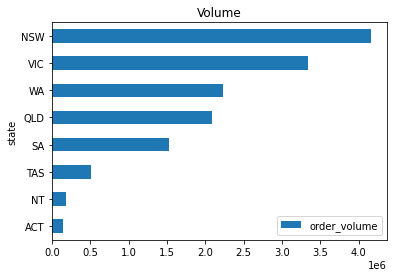
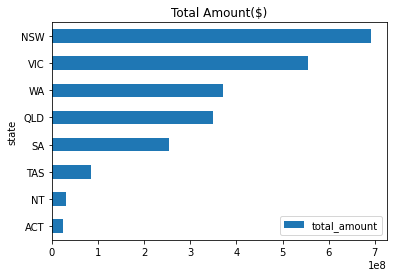
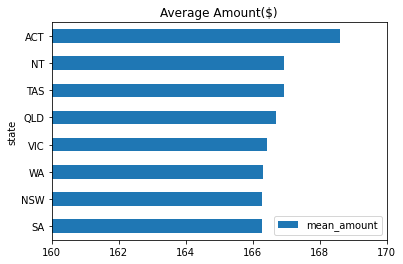

#### Transaction Datetime

Throughout the year (based on data from 2021), the daily average transaction amount saw an even distribution. The average transaction amount is also evenly distributed throughout the days of the week.
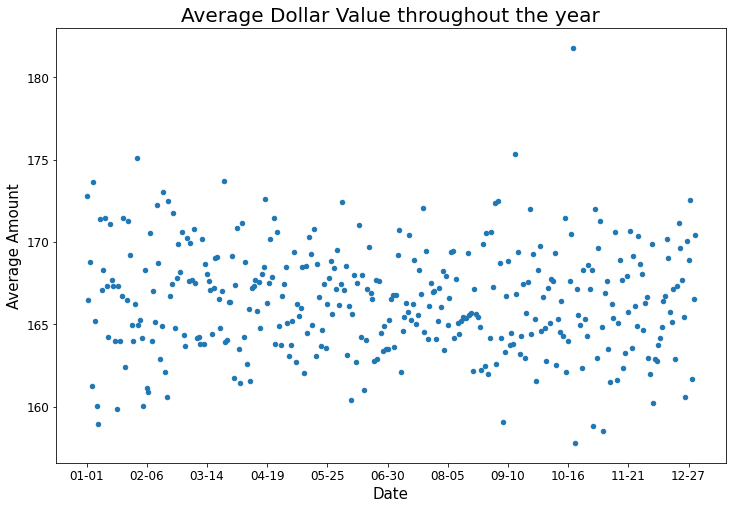
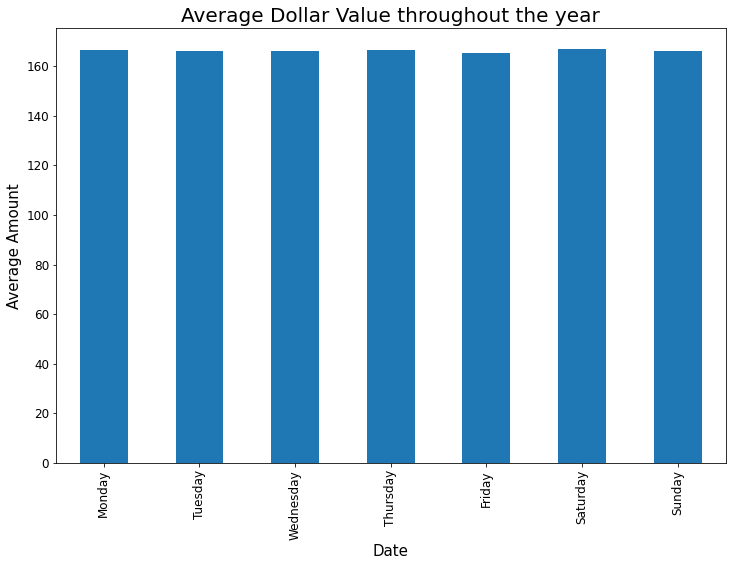

The overall distribution of transaction amount follows a log-normal distribution, with most of the transaction dollar value lying between \\$0 - \\$250. 
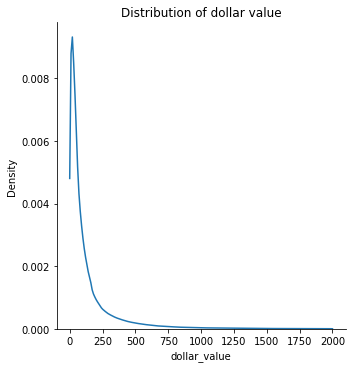

Merchants are categorised into five different revenue levels according to their revenue bands, with 'a' denoting the lowest band and 'e' denoting the highest band. Most of the merchants fall in the low to moderate revenue bands.
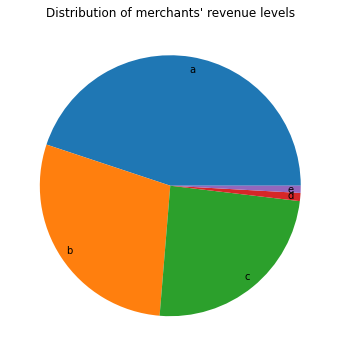

#### Feature Correlation
When running correlation analysis on the shortlisted census features with the transaction amounts, it appears that the correlation is very weak for all features. We also note that the median age has a moderate correlation with a number of features. Based on our further research, younger people are more likely to use the Buy Now, Pay Later service<sup>1</sup>. Hence, out of the shortlisted census features, we decide to retain only the median age of SA2 population.

<sup>[1] Jolly, W - Financial Journalist</sup>
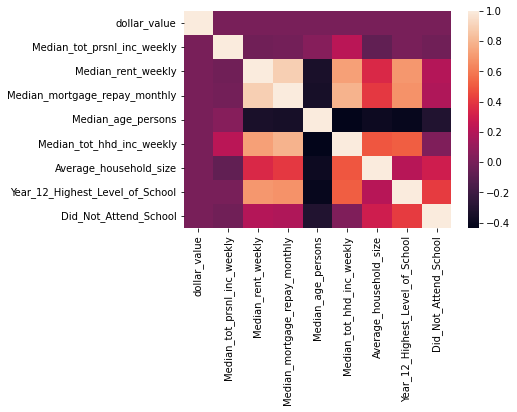

## 4. Feature Modelling

Before feeding features into the ranking system, some features need to be modelled to generate predictions on future data.

### Average take amount and transaction volume in the next 365 days with time-series modelling

As we have time series data in hand, we will use SARIMAX (Seasonal Auto-Regressive Integrated Moving Average), an autoregressive model that uses past data to forecast future data, using lagged values $(p)$, moving average $(q)$, differencing $(d)$, and seasonality $(P,D,Q,s)$.

The `SARIMAX` model takes a few hyperparameters $SARIMA(p,d,q)x(P,D,Q,s)$:
- We set $s=7$, since the granularity of the data is daily, and the closest period is a week (7 days)
- We use a stepwise algorithm (using AIC as selection criterion) to figure out the rest

In [ ]:
# Import Libraries
# !pip3 install tqdm
# !pip3 install pyramid-arima

from pyspark.sql import SparkSession, functions as F, DataFrame
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm
import warnings

import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import pmdarima as pm

# Filter out some warnings
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)

In [ ]:
# Read in preprocessed data
cleaned_data = spark.read.parquet('../data/curated/cleaned_data.parquet/')
cleaned_data = cleaned_data.withColumn("take_amt", F.col("take rate")*F.col("dollar_value")/100)

# Group Data and transform into time series data
ts = cleaned_data.groupBy(['merchant_abn', 'order_datetime']).agg(
    F.mean("take_amt").alias("mean_take_amt"),
    F.count("*").alias("transaction_count"),
)
ts_pd = ts.toPandas()
ts_pd = ts_pd.sort_values(by=['order_datetime','merchant_abn'])
ts_pd['order_datetime'] = pd.to_datetime(ts_pd['order_datetime'])

# Get the ABN's of all merchants in a set
merchants = sorted(set(ts_pd['merchant_abn']))

In [ ]:
# Use one merchant as an example to determine model
test_data = ts_pd.loc[ts_pd['merchant_abn']==10142254217]
test_data = test_data.set_index('order_datetime')

#### Forecast on average take amount (take rate * dollar value)

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel_take_amt = pm.auto_arima(test_data['mean_take_amt'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel_take_amt.summary()

From the output, `SARIMA(1,0,0)x(2,1,0,7)` is the best model, hence we use it in our final forecasting model.

The following figure shows a visual example of the forecast result for one of the merchaants.
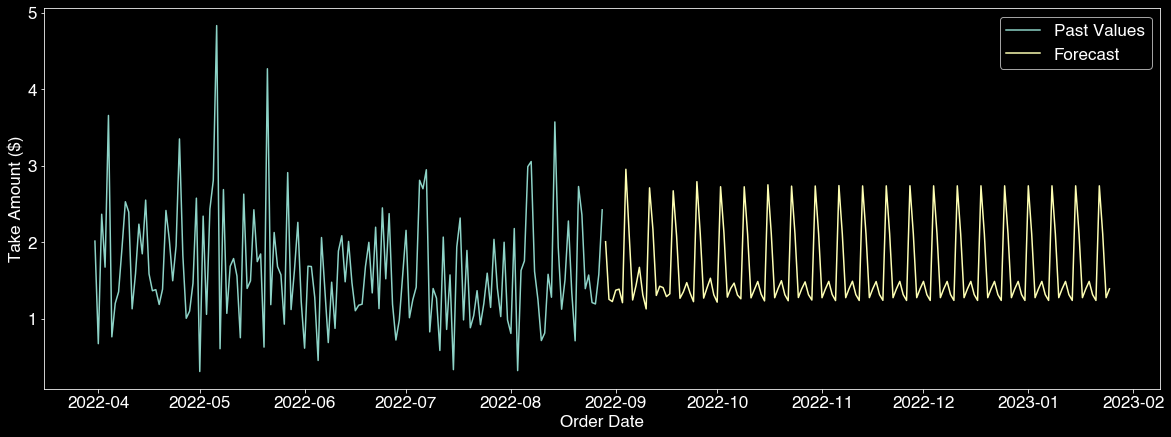

#### Forecast on average transaction volume

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel_transaction_count = pm.auto_arima(test_data['transaction_count'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel_transaction_count.summary()

From the output, `SARIMA(1,0,1)x(2,1,0,7)` is the best model, hence we use it in our final forecasting model.

Deploying the models for forecasting:
- For merchants with insufficient amount of data, a time series model cannot be built, hence we take the average of their data as our forecast
- For the rest, we build 2 `SARIMA` models for each merchant on the 2 key performance indicators
    - We generate forecast for the next year (365 days, since we have about $\leq$ 2 years of data) and average it

In [ ]:
# Show forecast data
predictions = pd.read_csv('../data/curated/future_predictions.csv')
predictions.head()

### Merchant and customer fraud rate with Logistic Regression
We want to evaluate the average fraudulent occurrences for each merchant / customer over the course of all available data as their respective fraud rate. To achieve this, we apply Logistic Regression to train on the day of week, transaction volume, and average transaction amount to classify if the transaction activity on this day is fraudulent or not. We assume that all merchants and customers are not inherently fraudulent, that is, the fraudulent occurrence is independent of who the merchant / customer is.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

In [ ]:
# read in datasets
merchant_fraud = spark.read.parquet('../data/curated/merchant_fraud.parquet')
consumer_fraud = spark.read.parquet('../data/curated/consumer_fraud.parquet')

In [ ]:
print("Fraudulent entries percentage of merchants: ", 
      100 * merchant_fraud.where(F.col('fraud_probability') != 0.01).count() / merchant_fraud.count())

print("Fraudulent entries percentage of custoemrs: ", 
      100 * consumer_fraud.where(F.col('fraud_probability') != 0.01).count() / consumer_fraud.count())

About 0.008% of the merchant daily transactions and 0.4% of the consumer daily transactions are fraudulent.

Since the proportion of non-fraud to fraud data in both merchant and consumer fraud datasets is highly imbalanced, resampling is performed on both datasets before fitting a model.

For both training datasets, the proportion used is 550 samples of non-fraud data and 450 samples of fraud data. The proportion of non-fraud data is slightly higher since it represents the majority of the data.

In [ ]:
def resampling(majority, minority):
    """
    Performs undersampling on the majority class (spark dataframe)
    and oversampling on the minority class (pandas dataframe) from an imbalanced dataset. 
    Outputs resampled dataset as a pandas dataframe.
    """
    
    # define number of samples needed from each class
    N_MAJOR = 550
    N_MINOR = 450
    FRAC_MAJOR = N_MAJOR / majority.count()
    
    # repeated sampling from the minority class
    n_more_samples = N_MINOR - minority.shape[0] # needs to be less than no. of samples in minority
    if n_more_samples > 0:
        sampled_minority = pd.concat([minority, resample(minority, replace=True, n_samples=n_more_samples, random_state=0)], axis=0)
    else:
        sampled_minority = minority
    
    # undersampling from the majority class
    sampled_majority = majority.sample(FRAC_MAJOR, seed=0).toPandas()
    
    # join the sampled datasets
    resampled = pd.concat([sampled_majority, sampled_minority], axis=0)
    
    return resampled

#### Model training pipeline (using merchant data as example)

In [ ]:
# split merchant fraud data by class
merchant_majority = merchant_fraud.where(F.col('fraud_probability') == 0.01)
merchant_minority = merchant_fraud.where(F.col('fraud_probability') != 0.01).toPandas()

# obtain resampled dataset for modelling
merchant_resampled = resampling(merchant_majority, merchant_minority)
merchant_resampled.head()

In [ ]:
# parse order datetime column to pandas' datetime
merchant_resampled['order_datetime'] = pd.to_datetime(merchant_resampled['order_datetime'])

# create order day of week column - Monday = 0, Sunday = 6
merchant_resampled['order_dayofweek'] = merchant_resampled['order_datetime'].dt.day_of_week

# one-hot encoding on order day of week column
merchant_resampled = pd.get_dummies(data=merchant_resampled, prefix='dow', columns=['order_dayofweek'])

merchant_resampled.head()

In [ ]:
# split dataset into predictors and target variables
X = pd.concat([merchant_resampled.iloc[:,2:4], merchant_resampled.iloc[:,6:]], axis=1)
y = merchant_resampled.iloc[:,4]

# convert target variable from boolean to integers
y = y.replace({True: 1, False: 0})

In [ ]:
# cross validation
lgr_merchant = LogisticRegression(max_iter=250)
acc_scores = cross_val_score(lgr_merchant, X, y, scoring='accuracy', cv=3)
f1_scores = cross_val_score(lgr_merchant, X, y, scoring='f1', cv=3)
print(acc_scores)
print('Average cross-validation accuracy: ', np.mean(acc_scores))
print(f1_scores)
print('Average cross-validation F1 score: ', np.mean(f1_scores))

The same pipeline is also applied to the customer data.

The model is then fitted to the entire datasets and generate predictions (fraudulent / non-fraudulent label) for each entry. The fraud rate is calculated as the average fraudulent occurrences of each merchant / customer.

## 5. Merchant segmentation

The 4026 merchants are segmented based on the tags given about their business field. The stop words in the tag field are removed to only retain representative keywords. These keywords are one-hot encoded for K-means clustering to be performed.

The cohesion and separation of clusters are evaluated using silhouette score. It is found that between 3 and 5 clusters, 5-means clustering produced the highest silhouette score. Thus, the merchants are to be segmented into 5 segments.

These 5 segments are identified as Appliances, Accessories, Gardening, IT Service, and Furniture. More than 80% of merchants belong to the Appliances and Accessories segments.
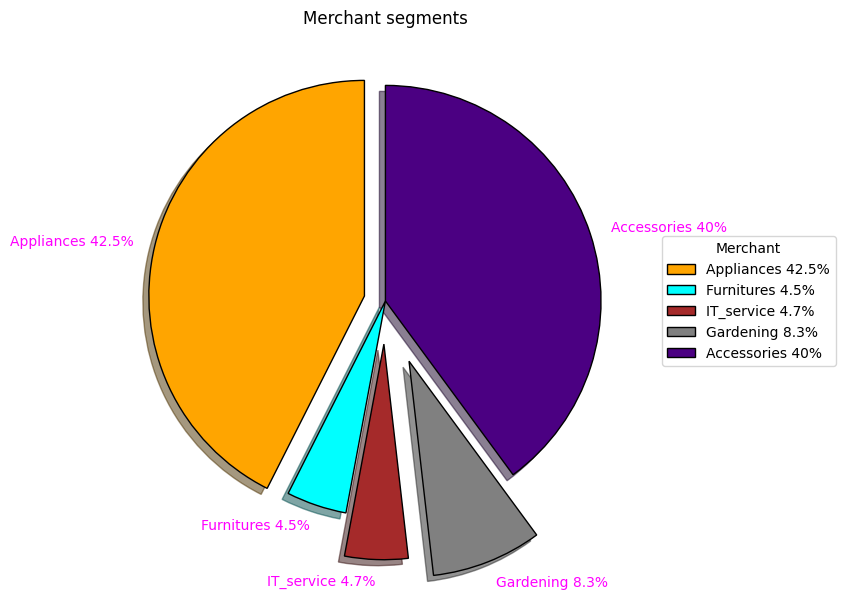

## 6. Ranking System

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, functions as F

from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import Layout

spark = (
    SparkSession.builder.appName("Ranking Merchants")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [53]:
ranking_properties = spark.read.csv('../data/curated/merchant_ranking_properties.csv/', header = True).toPandas()
merchant_names = spark.read.parquet('../data/tables/tbl_merchants.parquet').toPandas()
merchant_names = merchant_names[['merchant_abn', 'name']]
ranking_properties = ranking_properties.astype(float)
segments = pd.read_csv('../data/curated/segmented_merchants.csv')

In [54]:
segments = segments[['merchant_abn', 'merchant_segments']]
segments['merchant_abn'] = segments['merchant_abn'].astype(int)

In [55]:
ranking_properties = ranking_properties.merge(segments, on = 'merchant_abn')

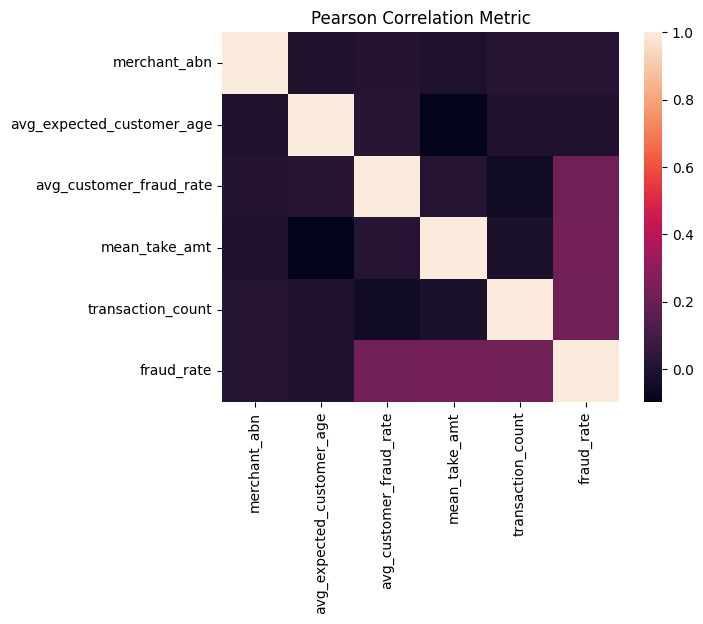

In [56]:
sns.heatmap(ranking_properties.corr())

plt.title('Pearson Correlation Metric')
plt.savefig('../plots/ranking_features_correlation.png', bbox_inches='tight')
plt.show()

Merchant fraud rate 'fraud_rate' is slightly correlated with other features but not strongly enough to remove it


### Set-up for Different Ranking Methods

#### Weighted Average Rank

Percentile ranking on each feature is calculated for every merchant.

In [57]:
# Set whether we want to rank feature in ascending or descending order (if we prefer feature lower or higher)
from pyspark.sql.types import NullType


ascending = {'avg_expected_customer_age': True, 'avg_customer_fraud_rate': True, 'mean_take_amt': False, 'transaction_count': False, 'fraud_rate': True}

# Get ranking on each feature for every merchant

def get_merchant_percent_ranks(segment):

    if segment == 'All': 
        ranking_properties_segment = ranking_properties.set_index('merchant_abn')
    
    else:
        ranking_properties_segment = ranking_properties.loc[ranking_properties['merchant_segments'] == segment].set_index('merchant_abn')

    ranks = []

    #print(ranking_properties_segment)

    for col_name in (ranking_properties.columns)[1:6]:
        #print(col_name)
        ranking_properties_segment[col_name + '_rank'] = ranking_properties_segment[col_name].rank(ascending = ascending[col_name], pct = True)
        ranks.append(col_name + '_rank')
    
    #print(ranking_properties_segment)
    merchant_percent_ranks = ranking_properties_segment[ranks]

    merchant_percent_ranks_join = merchant_percent_ranks.reset_index()
    merchant_percent_ranks_join['merchant_abn'] = merchant_percent_ranks_join['merchant_abn'].astype(int)

    #ranking_properties_segment = ranking_properties.drop(ranks, axis = 1)

    return merchant_percent_ranks, merchant_percent_ranks_join

#### Weighted Normalised Ranking

Normalised value for all features (between 0 and 1) is calculated.

Features that we want to be lower are changed so that they are negative (thus, when we use weights to sum values maximum sum will be best).

In [58]:
def get_merchant_normalised_values(segment):

    if segment == 'All': 
        ranking_properties_segment = ranking_properties.set_index('merchant_abn').drop(['merchant_segments'], axis = 1)
    
    else:
        ranking_properties_segment = ranking_properties.loc[ranking_properties['merchant_segments'] == segment].set_index('merchant_abn').drop(['merchant_segments'], axis = 1)

    merchant_normalised_features = (ranking_properties_segment-ranking_properties_segment.min())/(ranking_properties_segment.max()-ranking_properties_segment.min())

    for col_name in merchant_normalised_features:
        if ascending[col_name]:
            merchant_normalised_features[col_name] = -1*merchant_normalised_features[col_name]

    merchant_normalised_features_join = merchant_normalised_features.reset_index()
    merchant_normalised_features_join['merchant_abn'] = merchant_normalised_features_join['merchant_abn'].astype(int)

    return merchant_normalised_features, merchant_normalised_features_join

### Interactive Ranking System

In [59]:
# Set initial (internal) weights

w1 = 0.1 # Internal age weight
w2 = 1 # Internal customer fraud weight
w3 = 0.6 # Internal avg take amount weight
w4 = 1 # Internal transaction count weight
w5 = 1 # Internal merchant fraud weight

ranking_type = 'weighted average ranking'

In [68]:
from ipywidgets import interact_manual, widgets, Layout
from numpy._typing import _NBitLongDouble
from pyspark.sql.types import NullType

def weighted_average_rank(w1, w2, w3, w4, w5, segment):
    merchant_percent_ranks, merchant_percent_ranks_join = get_merchant_percent_ranks(segment)

    #print(merchant_percent_ranks)

    merchant_percent_ranks['weighted_average_rank'] = w1*merchant_percent_ranks['avg_expected_customer_age_rank'] + w2*merchant_percent_ranks['avg_customer_fraud_rate_rank']\
         + w3*merchant_percent_ranks['mean_take_amt_rank'] + w4*merchant_percent_ranks['transaction_count_rank']\
             + w5*merchant_percent_ranks['fraud_rate_rank']
    merchant_percent_ranks['rank'] = merchant_percent_ranks['weighted_average_rank'].rank()
    merchant_ranking = merchant_percent_ranks.sort_values(by=['rank'])['rank'].to_frame()
    merchant_ranking = merchant_ranking.reset_index()
    merchant_ranking['merchant_abn'] = merchant_ranking['merchant_abn'].astype(int)
    merchant_ranking = merchant_ranking.merge(merchant_names, on = 'merchant_abn', how = 'outer').set_index('rank')
    merchant_ranking = merchant_ranking.merge(merchant_percent_ranks_join, on = 'merchant_abn', how = 'outer')
    merchant_ranking = merchant_ranking.merge(segments, on = 'merchant_abn', how = 'outer')
    return merchant_ranking

def weighted_normalised_rank(w1, w2, w3, w4, w5, segment):

    merchant_normalised_features, merchant_normalised_features_join = get_merchant_normalised_values(segment)

    merchant_normalised_features['weighted_normalised_value'] = w1*merchant_normalised_features['avg_expected_customer_age'] + w2*merchant_normalised_features['avg_customer_fraud_rate']\
         + w3*merchant_normalised_features['mean_take_amt'] + w4*merchant_normalised_features['transaction_count']\
             + w5*merchant_normalised_features['fraud_rate']
    merchant_normalised_features['rank'] = merchant_normalised_features['weighted_normalised_value'].rank(ascending = False)
    merchant_ranking = merchant_normalised_features.sort_values(by=['rank'])['rank']
    merchant_ranking = merchant_ranking.reset_index()
    merchant_ranking['merchant_abn'] = merchant_ranking['merchant_abn'].astype(int)
    merchant_ranking = merchant_ranking.merge(merchant_names, on = 'merchant_abn', how = 'outer').set_index('rank')
    merchant_ranking = merchant_ranking.merge(merchant_normalised_features_join, on = 'merchant_abn', how = 'outer')
    merchant_ranking = merchant_ranking.merge(segments, on = 'merchant_abn', how = 'outer')
    return merchant_ranking
    

def update(customer_age_weight=w1, customer_fraud_weight=w2, mean_take_amt_weight=w3, transaction_count_weight=w4, fraud_rate_weight=w5,ranking_strategy=ranking_type, segment = 'All'):
    if ranking_strategy == 'weighted average rank':
        return weighted_average_rank(customer_age_weight, customer_fraud_weight, mean_take_amt_weight, transaction_count_weight, fraud_rate_weight, segment).head(10)
    elif ranking_strategy == 'weighted normalised ranking':
        return weighted_normalised_rank(customer_age_weight, customer_fraud_weight, mean_take_amt_weight, transaction_count_weight, fraud_rate_weight, segment).head(10)
    return

im = interact_manual(update, customer_age_weight=(0, 1.0, 0.01), customer_fraud_weight=(0, 1.0, 0.01), mean_take_amt_weight=(0, 1.0, 0.01), \
    transaction_count_weight=(0, 1.0, 0.01), fraud_rate_weight=(0, 1.0, 0.01), ranking_strategy=['weighted average rank', 'weighted normalised ranking'], segment=['All', 'Gardening', 'Appliances', 'Furnitures', 'IT service', 'Accessories']);

descriptions = ['Customer Age Weight----', 'Customer Fraud Weight--', 'Take Amount Weight-----', 'Transaction Count Weight', 'Merchant Fraud Weight---']

for i in range(0,5):
    im.widget.children[i].style = {'description_width': 'initial'}
    im.widget.children[i].layout = Layout(width = '45%')
    im.widget.children[i].description = descriptions[i]

im.widget.children[5].description = 'Ranking Strategy'
im.widget.children[5].style = {'description_width': 'initial'}
im.widget.children[6].description = 'Segment'
im.widget.children[7].description = 'Find Ranking'

display(im)

interactive(children=(FloatSlider(value=0.1, description='customer_age_weight', max=1.0, step=0.01), FloatSlid…

<function __main__.update(customer_age_weight=0.1, customer_fraud_weight=1, mean_take_amt_weight=0.6, transaction_count_weight=1, fraud_rate_weight=1, ranking_strategy='weighted average ranking', segment='All')>

### Ranking the Top Merchants

Weighted average rank is preferred because it is more resilient to extreme outliers.

From research, BNPL groups are primarily affiliated with large corporations with lots of sales, therefore, for rankings we will heavily weight transaction count. Additionally, they often offer 'no fraud liability' to merchants, meaning they are out of pocket for fraud, leading to high prioritisation of low-fraud merchants (again reflected by the weights).

#### Top 100 Overall

In [90]:
top_100 = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'All').head(100)
top_100

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank,merchant_segments
0,45380641195,Nisl Arcu Iaculis Incorporated,0.521361,0.191505,0.227273,0.094883,0.345877,Appliances
1,42543374304,Morbi Metus Vivamus Inc.,0.288127,0.217089,0.158470,0.145554,0.345877,IT service
2,86871438193,Nunc Interdum Inc.,0.545951,0.200199,0.152509,0.142325,0.345877,Gardening
3,88279777843,Ante Maecenas LLC,0.571038,0.174118,0.176602,0.153502,0.345877,Appliances
4,87771712045,Vivamus Sit LLC,0.695231,0.185296,0.159463,0.155489,0.345877,IT service
...,...,...,...,...,...,...,...,...
95,75902032169,Accumsan Neque Consulting,0.489319,0.231495,0.320169,0.181073,0.345877,Appliances
96,45783766755,Purus Duis Corp.,0.381520,0.340288,0.202186,0.154496,0.345877,Appliances
97,67244956961,Vehicula Industries,0.144809,0.064332,0.250869,0.427720,0.345877,Appliances
98,43321695302,Ante Limited,0.544213,0.270243,0.364133,0.114009,0.345877,Appliances


4 out of the top 10 merchants are IT Services, despite the relatively small size of this segment

#### Top 10 merchants by segment

##### Gardening

In [63]:
top_10_gardening = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Gardening').head(10)
top_10_gardening

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,86871438193,Nunc Interdum Inc.,0.546547,0.195195,0.138138,0.135135,0.399399
1,74063123996,Nec Eleifend Non Ltd,0.423423,0.261261,0.186186,0.072072,0.399399
2,75850458091,Dictum Sapien Incorporated,0.450450,0.267267,0.204204,0.099099,0.399399
3,29639699851,Sodales Elit Erat Corporation,0.453453,0.384384,0.159159,0.045045,0.399399
4,23692710924,Integer Urna Corporation,0.246246,0.282282,0.156156,0.192192,0.399399
5,90672655190,Nullam Vitae Foundation,0.261261,0.156156,0.420420,0.165165,0.399399
6,38012560280,In Tempus Associates,0.507508,0.381381,0.228228,0.048048,0.399399
7,25938405651,Elementum Dui Quis Ltd,0.528529,0.234234,0.486486,0.042042,0.399399
8,67692278478,Nullam LLP,0.402402,0.039039,0.180180,0.438438,0.399399
9,49925232405,Aliquam Tincidunt Nunc PC,0.441441,0.114114,0.528529,0.156156,0.399399


##### Appliances

In [64]:
top_10_appliances = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Appliances').head(10)
top_10_appliances

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,45380641195,Nisl Arcu Iaculis Incorporated,0.520724,0.191477,0.217163,0.098074,0.355517
1,88279777843,Ante Maecenas LLC,0.573847,0.173964,0.171045,0.155283,0.355517
2,49536733338,Duis A Ltd,0.497957,0.231757,0.189142,0.131932,0.355517
3,24015173965,Lectus Limited,0.571512,0.237595,0.250438,0.105663,0.355517
4,98416475066,Lacinia Orci PC,0.305896,0.252189,0.310566,0.081728,0.355517
5,88358066529,Pede Cras Vulputate Consulting,0.319323,0.365441,0.056626,0.124927,0.355517
6,62135501337,Pede Corp.,0.401635,0.129013,0.075306,0.342674,0.355517
7,66571984047,Volutpat Company,0.352014,0.183304,0.338587,0.137770,0.355517
8,19986358096,Hendrerit Donec Company,0.394046,0.214828,0.256276,0.154699,0.355517
9,45899477665,At Incorporated,0.446585,0.308231,0.179802,0.109165,0.355517


##### Furnitures

In [65]:
top_10_furnitures = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Furnitures').head(10)
top_10_furnitures

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,88402174457,Duis Dignissim LLC,0.593407,0.269231,0.252747,0.093407,0.32967
1,24471518053,Enim Suspendisse Aliquet LLP,0.587912,0.313187,0.318681,0.082418,0.32967
2,46533246372,Ut Quam Inc.,0.252747,0.307692,0.175824,0.208791,0.32967
3,92636306985,Ornare Incorporated,0.692308,0.302198,0.236264,0.175824,0.32967
4,28556213345,Eu Augue Ltd,0.675824,0.274725,0.219780,0.219780,0.32967
5,26148653604,Volutpat Nulla Incorporated,0.494505,0.340659,0.445055,0.049451,0.32967
6,90578415511,A Scelerisque Foundation,0.450549,0.296703,0.549451,0.038462,0.32967
7,77690613296,Cursus Et Eros Corp.,0.659341,0.368132,0.351648,0.087912,0.32967
8,10323485998,Nunc Inc.,0.686813,0.406593,0.329670,0.060440,0.32967
9,86182863634,Luctus Vulputate Nisi Institute,0.626374,0.390110,0.214286,0.153846,0.32967


##### IT service

In [66]:
top_10_it_service = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'IT service').head(10)
top_10_it_service

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,42543374304,Morbi Metus Vivamus Inc.,0.298429,0.272251,0.026178,0.157068,0.471204
1,87771712045,Vivamus Sit LLC,0.732984,0.225131,0.031414,0.167539,0.471204
2,63978837398,In Tincidunt PC,0.748691,0.246073,0.036649,0.172775,0.471204
3,45244796758,Vitae Dolor LLP,0.507853,0.319372,0.151832,0.057592,0.471204
4,22027671078,Mauris Magna Industries,0.340314,0.293194,0.209424,0.104712,0.471204
5,24351356445,At Pede Cras Corp.,0.251309,0.198953,0.094241,0.303665,0.471204
6,22526511302,Semper Et Incorporated,0.513089,0.382199,0.068063,0.162304,0.471204
7,16165222459,Vehicula Pellentesque LLP,0.591623,0.157068,0.162304,0.335079,0.471204
8,88249446460,Pellentesque Habitant Morbi Institute,0.570681,0.235602,0.450262,0.099476,0.471204
9,55958301764,Eget Magna Ltd,0.738220,0.308901,0.109948,0.251309,0.471204


##### Accessories

In [67]:
top_10_accessories = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Accessories').head(10)
top_10_accessories

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,70893725439,Luctus Curabitur Incorporated,0.323584,0.181083,0.137523,0.210330,0.312694
1,27585113425,Dolor Dolor Limited,0.446173,0.134412,0.228376,0.205352,0.312694
2,73489866331,Eu Dui Cum Company,0.479154,0.200996,0.233354,0.147480,0.312694
3,69418675752,Donec PC,0.393279,0.168637,0.139390,0.283759,0.312694
4,88553358884,Sed Consequat Limited,0.353454,0.229620,0.401369,0.075918,0.312694
5,41827752591,Fusce Aliquam Consulting,0.317984,0.092097,0.443062,0.192906,0.312694
6,95184414711,Ut Eros Incorporated,0.200996,0.172371,0.388301,0.159303,0.312694
7,60650953328,Integer LLC,0.340386,0.263223,0.331052,0.095831,0.312694
8,38736067045,Cras Lorem Institute,0.417548,0.255134,0.367144,0.082141,0.312694
9,20325086904,Vivamus Rhoncus Ltd,0.505289,0.265713,0.337274,0.080896,0.312694


### Insights

In [87]:
weighted_average_rank(w1, w2, w3, w4, w5, segment = 'All').reset_index().groupby('merchant_segments').mean().iloc[:, 0:1].rename(columns = {'index': 'average rank'})

,average rank
merchant_segments,
Accessories,2143.505912
Appliances,1999.471687
Furnitures,1969.280220
Gardening,1740.909910
IT service,1541.801047


IT service has considerably lower average rank than the other segments.

In [88]:
weighted_average_rank(w1, w2, w3, w4, w5, segment = 'All').reset_index().groupby('merchant_segments').std().iloc[:, 0:1].rename(columns = {'index': 'standard deviation'})

,standard deviation
merchant_segments,
Accessories,1101.004735
Appliances,1196.509592
Furnitures,1198.519982
Gardening,1187.708761
IT service,1068.236556


Spread of rankings is similar for all segments.

In [95]:
overall_ranks = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'All').reset_index().rename(columns = {'index': 'rank'})

#### Distribution of Ranks for each Segment

##### IT Services

(array([31., 27., 25., 20., 24., 22., 13., 15.,  8.,  6.]),
 array([1.0000e+00, 4.0090e+02, 8.0080e+02, 1.2007e+03, 1.6006e+03,
        2.0005e+03, 2.4004e+03, 2.8003e+03, 3.2002e+03, 3.6001e+03,
        4.0000e+03]),
 <BarContainer object of 10 artists>)

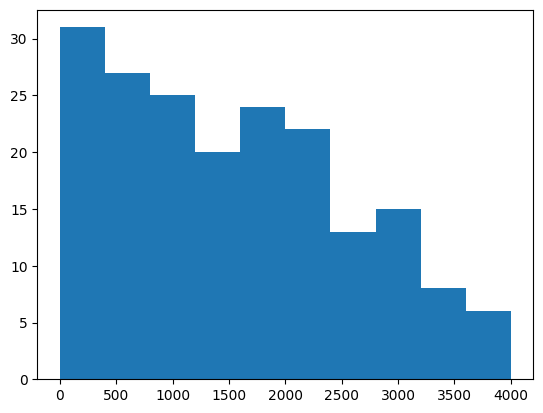

In [101]:
it_services = overall_ranks.where(overall_ranks.merchant_segments == 'IT service')
plt.hist(it_services['rank'], bins = 10)

##### Accessories

(array([106., 137., 144., 178., 159., 186., 189., 164., 171., 173.]),
 array([   5. ,  406.9,  808.8, 1210.7, 1612.6, 2014.5, 2416.4, 2818.3,
        3220.2, 3622.1, 4024. ]),
 <BarContainer object of 10 artists>)

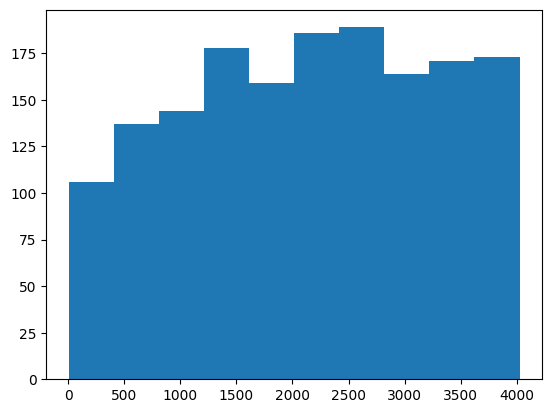

In [102]:
accessories = overall_ranks.where(overall_ranks.merchant_segments == 'Accessories')
plt.hist(accessories['rank'], bins = 10)

##### Appliances

(array([190., 174., 183., 156., 169., 158., 153., 164., 181., 185.]),
 array([   0. ,  402.5,  805. , 1207.5, 1610. , 2012.5, 2415. , 2817.5,
        3220. , 3622.5, 4025. ]),
 <BarContainer object of 10 artists>)

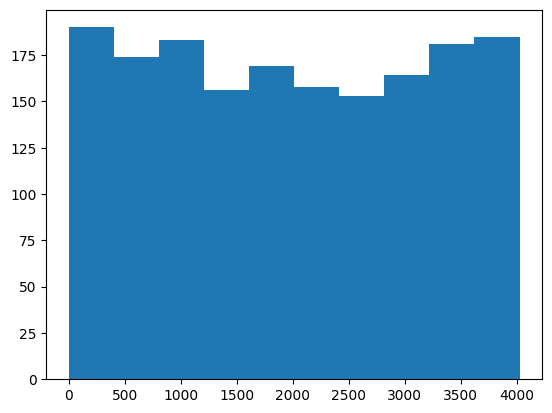

In [105]:
appliances = overall_ranks.where(overall_ranks.merchant_segments == 'Appliances')
plt.hist(appliances['rank'], bins = 10)

##### Furnitures

(array([27., 13., 20., 16., 19., 12., 17., 24., 17., 17.]),
 array([  21. ,  420.7,  820.4, 1220.1, 1619.8, 2019.5, 2419.2, 2818.9,
        3218.6, 3618.3, 4018. ]),
 <BarContainer object of 10 artists>)

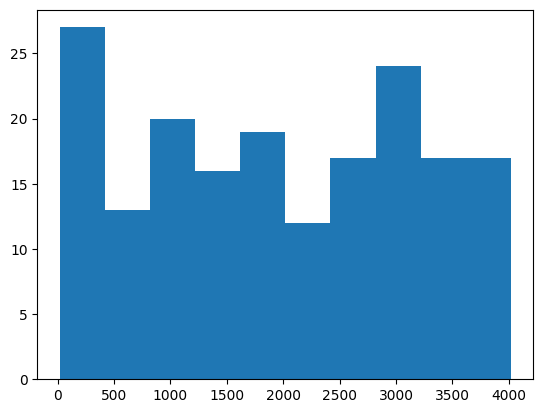

In [106]:
furnitures = overall_ranks.where(overall_ranks.merchant_segments == 'Furnitures')
plt.hist(furnitures['rank'], bins = 10)

##### Gardening

(array([50., 50., 32., 30., 34., 20., 27., 37., 28., 25.]),
 array([2.000e+00, 3.960e+02, 7.900e+02, 1.184e+03, 1.578e+03, 1.972e+03,
        2.366e+03, 2.760e+03, 3.154e+03, 3.548e+03, 3.942e+03]),
 <BarContainer object of 10 artists>)

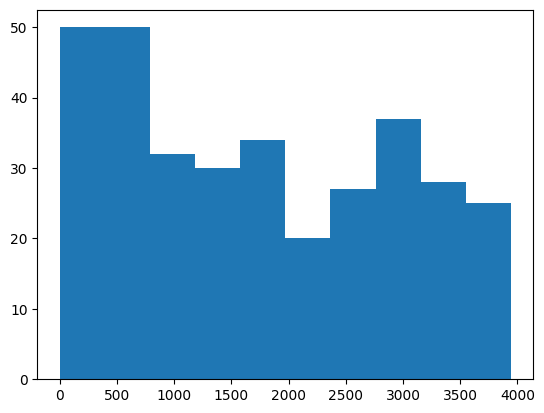

In [107]:
gardening = overall_ranks.where(overall_ranks.merchant_segments == 'Gardening')
plt.hist(gardening['rank'], bins = 10)